In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from datetime import datetime, timedelta

from pyproj import Geod
g = Geod(ellps='WGS84')

import sklearn
from sklearn.model_selection import train_test_split

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4

In [2]:
lon_min, lon_max = -49, -40
lat_min, lat_max = 59, 62

In [24]:
bathy = xr.open_dataset('../data/bathy/GEBCO_02_Dec_2022_8bb5cd71a07e/gebco_2022_n62.0_s59.0_w-49.0_e-40.0.nc')

gdp = xr.open_dataset('../data/GDP/processed_gdp_data.nc')

adsc_file = '../data/ADSC/geo_ekman_daily_gdp.nc'
adsc = xr.open_dataset(adsc_file).isel(depth=0)

In [25]:
DLON = []
DLAT = []
DTIME = []

for n_d in range(len(gdp.traj)):

    drifter = gdp.isel(traj=n_d)

    drifter = drifter.where(~np.isnan(drifter.lon), drop=True)

    drifter = drifter.isel(obs=np.arange(0, len(drifter.time), 4))

    DLON.append(drifter.lon.values)
    DLAT.append(drifter.lat.values)
    DTIME.append(drifter.time.values)

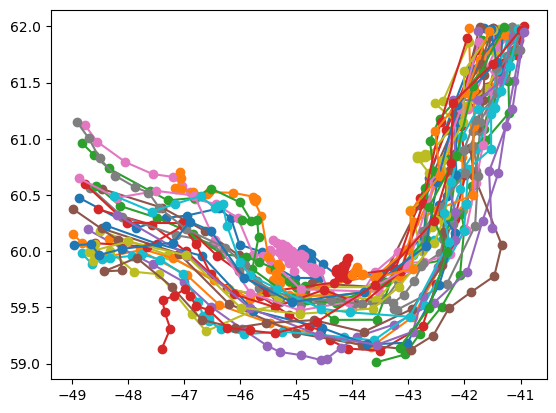

In [28]:
for i in range(len(DLON)):
    plt.plot(DLON[i], DLAT[i], 'o-')

In [29]:
lons = np.concatenate(DLON)
lats = np.concatenate(DLAT)
times = np.concatenate(DTIME)

#Convert np.datetime64 in datetime
timestamp = ((times - np.datetime64('1970-01-01T00:00:00'))/ np.timedelta64(1, 's'))
times = np.array([datetime.utcfromtimestamp(timestamp[i]) for i in range(len(timestamp))])

In [30]:
filenames = {'U': adsc_file,
             'V': adsc_file}

variables = {'U': 'uo',
             'V': 'vo'}
dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

fieldset_geoek = FieldSet.from_netcdf(filenames, variables, dimensions)

## CREATE AN "AGE" CONSTANT, TO REMOVE TOO OLD PARTICLES
fieldset_geoek.add_constant('maxage', 365.*86400)

class AgingParticle(JITParticle):
    age = Variable('age', dtype=np.float32, initial=0.)

def Age(particle, fieldset, time):
    particle.age = particle.age + math.fabs(5*60) #in seconds, !! CHECK THAT IT CORRESPONDS TO THE DT IN EXECUTE !!
    if particle.age > fieldset.maxage:
        particle.delete()


pset = ParticleSet(fieldset=fieldset_geoek, 
                   pclass=AgingParticle, 
                   lon=lons, 
                   lat=lats,
                   time=times
                  )

def DeleteParticle(particle, fieldset, time):
    particle.delete()

aging_kernel = pset.Kernel(Age)


In [ ]:
# output_file = pset.ParticleFile(name="../data/synthetic_trajectories/traj_sim_gdp.nc", outputdt=timedelta(hours=24))
# pset.execute(AdvectionRK4 + aging_kernel,
#              endtime=np.max(times)+timedelta(days=5),
#              dt=timedelta(minutes=5),
#              output_file=output_file, 
#              recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}
#             )


In [ ]:
# output_file.export()

In [ ]:
syn_traj = xr.open_dataset('../data/synthetic_trajectories/traj_sim_gdp.nc')

In [ ]:
def Return3days(i, synth_traj_data):
    
    lonref, latref, timeref = np.array(lons[i:i+4]), np.array(lats[i:i+4]), np.array(times[i:i+4])

    synth = synth_traj_data.isel(traj=i)
    lonsyn, latsyn, timesyn = synth.lon[:4*4:4].values, synth.lat[:4*4:4].values, synth.time[:4*4:4].values
    
    return lonref, latref, timeref, lonsyn, latsyn, timesyn


def SkillScore(lonref, latref, lonsyn, latsyn):

    d = g.inv(lonref, latref, lonsyn, latsyn)[2]
    dl = g.inv(lonref[:-1], latref[:-1], lonref[1:], latref[1:])[2]

    c = np.sum(d)/np.sum(np.cumsum(dl))

    if c > 1:
        s = 0
    else: 
        s = 1 - c

    return s

In [ ]:
longitudes = []
latitudes = []
scores = []
time_score = []

for i in range(len(ds.traj)-4):

    lonref, latref, timeref, lonsyn, latsyn, timesyn = Return3days(i, ds)

    scores.append(SkillScore(lonref, latref, lonsyn, latsyn))
    
    longitudes.append(lonref[0])
    latitudes.append(latref[0])
    time_score.append(timeref[0])
    
longitudes = np.array(longitudes)
latitudes = np.array(latitudes)
scores = np.array(scores)
time_score = np.array(time_score)

scores = np.array(scores)

good_lon = longitudes[(longitudes>-49)&(longitudes<-41)&(latitudes>59)&(latitudes<62)]
good_lat = latitudes[(longitudes>-49)&(longitudes<-41)&(latitudes>59)&(latitudes<62)]
good_score = scores[(longitudes>-49)&(longitudes<-41)&(latitudes>59)&(latitudes<62)]
good_timescore = time_score[(longitudes>-49)&(longitudes<-41)&(latitudes>59)&(latitudes<62)]

In [ ]:
def BootstrapSkillScore(data_input):

    taylor_skill = []

    for i in range(5000):

        mean_input = np.mean(sklearn.model_selection.train_test_split(data_input, test_size=0.1)[0])

        taylor_skill.append(mean_input)

    return np.around(np.mean(taylor_skill),2), np.around(np.std(taylor_skill)*1.96, 2)

In [ ]:
time_in_months_valid = pd.to_datetime(valid_time_ek).month
print(np.unique(time_in_months_valid))
augV = valid_score_ek[time_in_months_valid==8]
sepV = valid_score_ek[time_in_months_valid==9]
octoV = valid_score_ek[time_in_months_valid==10]

time_in_year_valid = pd.to_datetime(valid_time_ek).year

v2021 = valid_score_ek[time_in_year_valid==2021]

time_in_months = pd.to_datetime(good_timescore).month
jan = good_score[time_in_months==1]
feb = good_score[time_in_months==2]
mar = good_score[time_in_months==3]
apr = good_score[time_in_months==4]
may = good_score[time_in_months==5]
jul = good_score[time_in_months==7]
octo = good_score[time_in_months==10]
nov = good_score[time_in_months==11]
dec = good_score[time_in_months==12]

np.unique(time_in_months)

time_in_year = pd.to_datetime(good_timescore).year
np.unique(time_in_year)

y1996 = good_score[time_in_year==1996]
y1997 = good_score[time_in_year==1997]
y1998 = good_score[time_in_year==1998]
y2000 = good_score[time_in_year==2000]
y2002 = good_score[time_in_year==2002]
y2003 = good_score[time_in_year==2003]
y2006 = good_score[time_in_year==2006]
y2007 = good_score[time_in_year==2007]
y2014 = good_score[time_in_year==2014]
y2015 = good_score[time_in_year==2015]
y2017 = good_score[time_in_year==2017]
y2018 = good_score[time_in_year==2018]
y2019 = good_score[time_in_year==2019]
y2020 = good_score[time_in_year==2020]

In [ ]:
plt.figure(figsize=(8,8), dpi=300)
plt.subplot(211)

plt.fill_between([0, 15], 0.41, 0.5, color='grey', alpha=0.2)
plt.axhline(0.41, color='grey', alpha=0.3, lw=1)
plt.axhline(0.5, color='grey', alpha=0.3, lw=1)

data_to_plot = [jan, feb, mar, apr, may, jul, octo, nov, dec]
pos = [1,  2,  3,  4,  5,  7, 10, 11, 12]

plt.violinplot(data_to_plot, pos, showmeans=True, widths=0.8)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
       rotation=0, fontsize=13)
plt.ylim(0, 1.05)
plt.ylabel('SKILL SCORE', fontsize=14)

plt.violinplot([augV, sepV, octoV], [8, 9, 10], showmeans=True, widths=0.8)
plt.xlim(0, 14.2)

plt.text(12.65, 0.39, 'shelf', fontsize=13, c='grey')
plt.text(12.6, 0.48, 'ocean', fontsize=13, c='grey')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2)

plt.subplot(212)

plt.fill_between([1990, 2030], 0.41, 0.5, color='grey', alpha=0.2)
plt.axhline(0.41, color='grey', alpha=0.3, lw=1)
plt.axhline(0.5, color='grey', alpha=0.3, lw=1)

data_to_plot = [y1996, y1997, y1998, y2000, y2002, y2003, y2006, y2007, y2014, y2015, y2017, y2018, y2019, y2020]
pos = [1996, 1997, 1998, 2000, 2002, 2003, 2006, 2007, 2014, 2015, 2017, 2018, 2019, 2020]

plt.violinplot(data_to_plot, pos, showmeans=True, widths=0.8)

plt.violinplot([v2021], [2021], showmeans=True, widths=0.8)

plt.xticks(fontsize=13)
plt.ylim(0, 1.05)
plt.ylabel('SKILL SCORE', fontsize=14)

plt.scatter(2030, 0.5, s=200,  marker='s', label='GDP drifters', alpha = 0.5)
plt.scatter(2030, 0.5, s=200,  marker='s', label='GFWE+TERIFIC drifters', alpha = 0.5)
plt.scatter(2030, 0.5, s=200,  marker='s', label='Liu et al. (2014)', alpha = 0.4, color='grey')

plt.legend(loc='lower center', fontsize=12, bbox_to_anchor=(0.48, -0.01))
plt.xlim(1995, 2022)
plt.text(2007.7, 0.39, 'shelf', fontsize=13, c='grey')
plt.text(2007.5, 0.48, 'ocean', fontsize=13, c='grey')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2)


In [ ]:
mean, ci = BootstrapSkillScore(good_score)

cmap = sns.color_palette("mako", as_cmap=True)
bounds = np.arange(11)/10
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax, rect = createFigurewithProjection(figsize=(10, 10), nrows=1, ncols=1, bounds=[-49, -41, 59, 62])


ax.set_title('GDP DRIFTERS EVALUATION ', fontsize=15)

shapeAxis(ax, rect, addCoastline=True)

CS = ax.contour(lon_renske, lat_renske, -bathy_renske, transform=ccrs.PlateCarree(), colors='k', alpha=0.3)
ax.clabel(CS, CS.levels, inline=True, fontsize=11)


ax.text(-47.8, 61.6,'MEAN = '+str(mean)+' +/- '+str(ci)+' (95% C.I.)', c='k', transform=ccrs.PlateCarree(), fontsize=17)


pc = plt.hexbin(good_lon, good_lat, good_score, gridsize=60, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

cb = fig.colorbar(pc, fraction=0.036, pad=0.040)
cb.ax.tick_params(labelsize=14)
cb.set_label('SKILL SCORE', labelpad=15, y=0.50, rotation=90, fontsize=18)

